---
### **NOTA:** Toda la información producida durante el proyecto esta disponible en **https://drive.google.com/drive/folders/1v6ttK1kLlbDPv3gwIl_qY6QtO9HhZjMk?usp=sharing** el drive de Google: las bases de datos con los tweets descargados y procesados se encuentran como **archivos CSV** zipeados, asi como tambien los modelos de NLP (serializados con pickle).
---
# **TA_POLITICA-05_topic_modeling.ipynb**
>## ENTRADA:
>## **"all_tweets_db.csv"**  (drive: **all_tweets_db.zip** ) Todos los tweets en un solo dataframe
---
>## SALIDA:
>## **modelos serializados**

In [1]:
from platform import python_version
print(python_version())

3.7.7


In [2]:
import pandas as pd
import json
import re
import sys
import time
import random
import pickle
from datetime import datetime,timedelta, date
sys.version

'3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter

# Gensim
import gensim
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.models import CoherenceModel
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
nltk.download( 'stopwords' )
nltk.download( 'wordnet' )



# spacy
import spacy
from spacy_spanish_lemmatizer import SpacyCustomLemmatizer
# Ploteo
import pyLDAvis

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Cargamos el indice de politicos **"politicosdb.csv"**

In [4]:
%%time
db_politicos_csv = "politicosdb.csv"
politicosdb_df = pd.read_csv(db_politicos_csv )
politicosdb_df.sample(5)

Wall time: 8.96 ms


,id,screen_name,nombre,partido,nombre_partido,orientacion,total_tweets,tweets,fecha_creado,fecha_min,descripcion,num_seguidores
20,63195697,@RichardArcePeru,Richard Arce,np,nuevo peru,izq,10169,5535,2009-08-05,2009-07-29,Ex congresista de la República por el departam...,22803
66,4878461206,@Pedro_Olaechea,Pedro Olaechea,fp,fuerza popular,der,2885,2834,2016-02-05,2016-01-06,Mi experiencia está al servicio del Perú. Expr...,56216
11,318065421,@MirtyVas,Mirtha Vásquez,fa,frente amplio,izq,773,772,2011-06-15,2011-12-16,Congresista del Frente Amplio por Cajamarca y ...,2493
71,67978697,@rosamariabartra,Rosa María Bartra,fp,fuerza popular,der,8306,5171,2009-08-22,2009-06-09,"Abog, Quim. Farmacéutica, Docente.\nHija d Gri...",45047
30,1192891723,@geluseg,German Luna Segura,apra,apra,der,2022,2022,2013-02-18,2013-02-18,Analista y escritor.,446


### Cargamos **"all_tweets_db.csv"** ( tweets anotados con el target : **"orientacion"** y **"partido"**)

In [5]:
%%time
all_tweets_df = pd.read_csv("all_tweets_db.csv",keep_default_na=False )
#agregamos una text_tokens
all_tweets_df['text_tok']=all_tweets_df.text_prep.apply(lambda txt:txt.split())
all_tweets_df.sample(10)

Wall time: 2.37 s


,Date,text_prep,orientacion,partido,text_tok
551077,2011-07-16,avada kedavra,izq,nul,"[avada, kedavra]"
7401,2015-06-04,posible buscamos espacio acomode agendas,cen,ap,"[posible, buscamos, espacio, acomode, agendas]"
486567,2015-09-10,fenomeno niño viene sigue aguantando fondos go...,izq,fa,"[fenomeno, niño, viene, sigue, aguantando, fon..."
394655,2015-12-30,petroleo diesel,cder,app,"[petroleo, diesel]"
533249,2013-08-07,acabo desayunar tajada pizza media coca cola s...,izq,nul,"[acabo, desayunar, tajada, pizza, media, coca,..."
292528,2014-07-02,patologias obstetricas incluidas protocolo abo...,der,fp,"[patologias, obstetricas, incluidas, protocolo..."
430636,2019-06-24,sobrino milagros salazar solo estudios secunda...,izq,nul,"[sobrino, milagros, salazar, solo, estudios, s..."
556058,2020-2-1,arlette contreras lucha violencia mujer partidos,izq,nul,"[arlette, contreras, lucha, violencia, mujer, ..."
92168,2015-01-20,caviarada trabajo bajo ordenes montesinos haci...,der,fp,"[caviarada, trabajo, bajo, ordenes, montesinos..."
339201,2018-8-5,contratistas corruptos odebrecht roban ademas ...,der,fp,"[contratistas, corruptos, odebrecht, roban, ad..."


## Distribución de todos los tweets por fechas

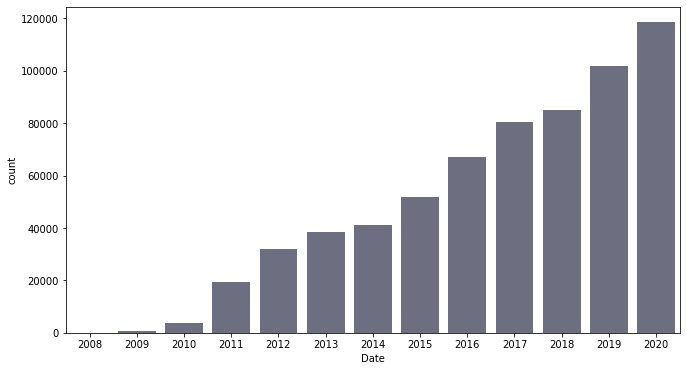

In [6]:
plt.figure(figsize=(11,6))
sns.countplot(all_tweets_df.Date.str[0:4] , color=(.42,.42,.52))

## TOPIC MODELING WITH LDA

In [7]:
all_tweets_df.text_tok

0         [harry, potter, cumple, años, hace, años, escr...
1         [2020, cambiar, logo, empresa, colores, arco, ...
2         [saboteado, votacion, dejando, debate, elimina...
3         [congresista, agradecio, organizaciones, viene...
4         [intervencion, debate, paridad, alternancia, i...
                                ...                        
639254         [mete, autogoles, cualquier, equipo, futbol]
639255                                       [correcaminos]
639256    [cuenta, fujitroll, busca, copiarse, francamen...
639257                                       [ayer, verdad]
639258    [tendencia, carla, garcia, consiguio, trabajo,...
Name: text_tok, Length: 639259, dtype: object

## Creamos bigramas y trigramas y los guardamos con *pickle*

In [12]:
%%time
serie_tmp=all_tweets_df.text_tok
bigram = gensim.models.Phrases(serie_tmp) #, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[serie_tmp]) #, threshold=100)  

# Una forma más rápida de conseguir trigrama/bigrama 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Wall time: 2min 19s


In [13]:
with open("gensim_bigram_model_Phraser.zip","wb") as f:
    pickle.dump(bigram_mod,f)
with open("gensim_trigram_model_Phraser.zip","wb") as f: 
    pickle.dump(trigram_mod,f)    

## PODEMOS CONTINUAR DESDE ACA CARGANDO CIERTOS MODELOS YA PRODUCIDOS

In [11]:
#bigram_mod = gensim.models.phrases.Phraser(bigram)
with open("gensim_bigram_model_Phraser.zip","rb") as f: 
    bigram_mod = pickle.load(f)
with open("gensim_trigram_model_Phraser.zip","rb") as f: 
    trigram_mod = pickle.load(f)  

In [228]:
orientacion='der'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
for a in range(200):
    print(trigram_mod[serie_tmp[a]])

['alocucion', 'almirante_jorge', 'montoya', 'pocos', 'lideres', 'nacionales', 'habla', 'fuerte_claro', 'felicitaciones']
['cobarde', 'vizcarra', 'quejandose', 'exigen', 'resolver_problemas', 'vienen', 'gobiernos_pasados', 'diferencia']
['pueblo', 'decia', 'mismo', 'habia', 'escucharlo', 'cerraba', 'congreso']
['podria', 'quejarse', 'gobierno', 'totalitarios', 'destruyan', 'imagenes', 'colon', 'latinoamerica']
['especie', 'sexto', 'estilo', 'ágatha', 'dice', 'paridad_alternancia', 'desast']
['victor_zamora', 'deje', 'momento', 'pensar', 'sueldo', 'cobra', 'camarilla', 'asesores', 'izquierda']
['martin_vizcarra', 'camas', 'pasar', 'fines_junio', 'camas', 'segun', 'sala_situacional']
['marc', 'anthony', 'david', 'beckham', 'donaron', 'construccion', 'albergue', 'niños_cancer', 'peru']
['ayer', 'pdte', 'dijo', 'casi', 'gritando', 'perú', 'fracasado', 'cierto', 'sobrevive', 'gracias', 'propio', 'cuidado', 'caer']
['luego', 'meses', 'profugo', 'comunista', 'gregorio_santos', 'capturado', 'so

In [229]:
orientacion='izq'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
for a in range(1200,1400):
    print(trigram_mod[serie_tmp[a]])

['votare', 'usted']
['pais', 'todas_sangres']
['realmente', 'gusta', 'claridad', 'simpleza', 'habla', 'muchas', 'izquierda', 'podrian']
['hecho', 'politica', 'negocio']
['ahora', 'mejor', 'debate', 'agenda_parlamentaria', '2020']
['gusto', 'escuchar', 'ojala', 'electo', 'lima']
['cochero', 'ingresar', 'congreso', 'necesitamos']
[]
['enrique_fernandez', 'debate', 'representante', 'nefasta', 'fujimontesinismo']
['enrique_fernandez', 'financiacion', 'partidos_politicos']
['retorno_bicameralidad', 'favor', 'respetar', 'dice', 'gente', 'prin']
['intervencion', 'rechaza', 'completamente', 'financiamiento', 'privados']
['bicameralidad', 'dice', 'personalmente', 'favor', 'respetar', 'voluntad_pueblo', 'expre']
['objetivo', 'empresa_privada', 'tendria', 'interes', 'colocar', 'dinero', 'partidos_politicos', 'congresistas', 'influ']
['enrique_fernandez', 'chacon', 'favor', 'bicameralidad']
['financiamiento_publico', 'solo', 'claro', 'sino', 'autentico']
['vivo', 'enrique_fernandez', 'frente_ampli

## WordCloud **por orientacion** removiendo las palabras mas comunes

# ----------------------------------------------------------------------------

In [70]:
#palabras comunes en politica y comunes en general
common_words = ['peru','gracias','solo','congreso', 'años','puede','gobierno','politica','estan','siempre','foto','nueva','hola','pais','debe',
                'hace','facebook','publique','ahora','estare','bien','tambien','cuenta', 'usted','creo','aqui','dice','gran','estan','vizcarra'
                'congresista','congresistas','peruano','mejor','toda','todo','buen','bueno','sera','cada','presidente','nadie','hacer','hilo','sino','mismo',
                'partido','caso','accion popular','keiko','apra','aprista','video lista','patria','roja','fuerza','popular','menos',
                 'solo','gracia','gracias' ]

def remove_common(text,common_words):
    #removemos stopwords
    text = text.split()
    important_words=[]
    for word in text:
        if word not in common_words:
            important_words.append(word)
            
    return  ' '.join(important_words)

## TOPIC MODELING WITH LDA
>### Cargamos los tweets particionados por orientacion política

In [8]:
orientacion_tweets_df_dict = {}  #diccionario con dataframes de tweets por orientacion
orientaciondf_dict = {}
conjunto_orientacion=set(politicosdb_df['orientacion'])
print("Cargando Orientaciones:")
for orientacion in conjunto_orientacion:    
    tweets_df = pd.read_csv(f"tweets-orientacion-db_{orientacion}.csv", keep_default_na=False )
    tweets_df['orientacion']=orientacion
    orientacion_tweets_df_dict[orientacion]=tweets_df.copy() 
    orientacion_tweets_df_dict[f"{orientacion}_len"]=len(tweets_df)
    orientaciondf_dict[orientacion]=politicosdb_df.loc[politicosdb_df['orientacion'] == orientacion] 
    print(f" {orientacion}" ,end="")
print("\nCompletada la carga.")

Cargando Orientaciones:
 nul cder cen cizq izq der
Completada la carga.


## TOPIC MODELING TWEETS DE IZQUIERDA

In [10]:
orientacion='izq'
NUM_TOPICS = 11

serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

ldamodel_izq = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel_izq.print_topics(num_words=7)

for topic in topics:
    print(topic)

(0, '0.022*"pais" + 0.019*"politica" + 0.018*"educacion" + 0.013*"bancada" + 0.012*"debe" + 0.010*"peru" + 0.010*"justicia" + 0.009*"corrupcion" + 0.009*"reforma"')
(1, '0.021*"violencia" + 0.018*"denuncia" + 0.014*"mujer" + 0.013*"mujeres" + 0.012*"region" + 0.011*"pedido" + 0.011*"foto" + 0.010*"constitucional" + 0.010*"decision"')
(2, '0.021*"facebook" + 0.018*"lucha" + 0.017*"mañana" + 0.013*"agua" + 0.013*"nacional" + 0.010*"lima" + 0.010*"proceso" + 0.010*"reunion" + 0.009*"distrito"')
(3, '0.055*"frente" + 0.036*"comision" + 0.035*"amplio" + 0.031*"congresista" + 0.026*"congreso" + 0.024*"proyecto" + 0.018*"nuevo" + 0.014*"debate" + 0.013*"publica"')
(4, '0.027*"vamos" + 0.024*"fujimorismo" + 0.021*"izquierda" + 0.016*"patria" + 0.014*"nunca" + 0.014*"derecha" + 0.011*"ayer" + 0.011*"acuerdo" + 0.011*"siempre"')
(5, '0.016*"fujimori" + 0.013*"keiko" + 0.013*"fuerza" + 0.013*"poder" + 0.012*"mismo" + 0.011*"congreso" + 0.010*"caso" + 0.010*"claro" + 0.010*"popular"')
(6, '0.016*"

>### guardamos el modelo

In [11]:
with open("gensim_lda_model_izq.zip","wb") as f:
    pickle.dump(ldamodel_izq,f)

## TOPIC MODELING TWEETS DE DERECHA

In [12]:

orientacion='der'
NUM_TOPICS = 10

serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

ldamodel_der = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel_der.print_topics(num_words=7)

for topic in topics:
    print(topic)


(0, '0.022*"pais" + 0.019*"politica" + 0.018*"educacion" + 0.013*"bancada" + 0.012*"debe" + 0.010*"peru" + 0.010*"justicia" + 0.009*"corrupcion" + 0.009*"reforma"')
(1, '0.021*"violencia" + 0.018*"denuncia" + 0.014*"mujer" + 0.013*"mujeres" + 0.012*"region" + 0.011*"pedido" + 0.011*"foto" + 0.010*"constitucional" + 0.010*"decision"')
(2, '0.021*"facebook" + 0.018*"lucha" + 0.017*"mañana" + 0.013*"agua" + 0.013*"nacional" + 0.010*"lima" + 0.010*"proceso" + 0.010*"reunion" + 0.009*"distrito"')
(3, '0.055*"frente" + 0.036*"comision" + 0.035*"amplio" + 0.031*"congresista" + 0.026*"congreso" + 0.024*"proyecto" + 0.018*"nuevo" + 0.014*"debate" + 0.013*"publica"')
(4, '0.027*"vamos" + 0.024*"fujimorismo" + 0.021*"izquierda" + 0.016*"patria" + 0.014*"nunca" + 0.014*"derecha" + 0.011*"ayer" + 0.011*"acuerdo" + 0.011*"siempre"')
(5, '0.016*"fujimori" + 0.013*"keiko" + 0.013*"fuerza" + 0.013*"poder" + 0.012*"mismo" + 0.011*"congreso" + 0.010*"caso" + 0.010*"claro" + 0.010*"popular"')
(6, '0.016*"

In [20]:
topics = ldamodel_der.print_topics(num_words=7)
for topic in topics:
    print(topic)
    
topics = ldamodel_izq.print_topics(num_words=7)
for topic in topics:
    print(topic)  

topics = ldamodel_cen.print_topics(num_words=7)
for topic in topics:
    print(topic) 


(0, '0.021*"comision" + 0.019*"politica" + 0.018*"justicia" + 0.015*"poder" + 0.013*"constitucion" + 0.012*"diario" + 0.012*"saludo"')
(1, '0.015*"sesion" + 0.014*"distrito" + 0.014*"democracia" + 0.013*"entrevista" + 0.013*"aniversario" + 0.011*"debate" + 0.011*"reforma"')
(2, '0.019*"salud" + 0.015*"gobierno" + 0.012*"ministro" + 0.009*"lucha" + 0.009*"pais" + 0.009*"peru" + 0.009*"gestion"')
(3, '0.032*"fujimori" + 0.018*"peru" + 0.014*"keiko" + 0.012*"columna" + 0.010*"indulto" + 0.010*"presidente" + 0.010*"ollanta"')
(4, '0.023*"humala" + 0.023*"congreso" + 0.021*"presidente" + 0.019*"vizcarra" + 0.015*"congresista" + 0.011*"comision" + 0.009*"martin"')
(5, '0.029*"gracias" + 0.019*"feliz" + 0.010*"pruebas" + 0.008*"muchas" + 0.007*"abrazo" + 0.007*"violencia" + 0.007*"juez"')
(6, '0.015*"bien" + 0.011*"peru" + 0.010*"mejor" + 0.009*"izquierda" + 0.009*"mañana" + 0.007*"pueblo" + 0.007*"politica"')
(7, '0.016*"toledo" + 0.015*"millones" + 0.014*"villaran" + 0.012*"susana" + 0.011*

In [13]:

with open("gensim_lda_model_der.zip","wb") as f:
    pickle.dump(ldamodel_der,f)

## TOPIC MODELING TWEETS DE CENTRO

In [14]:

orientacion='cen'
NUM_TOPICS = 11

serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

ldamodel_cen = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel_cen.print_topics(num_words=9)

for topic in topics:
    print(topic)


(0, '0.037*"peru" + 0.013*"comercio" + 0.013*"mundo" + 0.011*"mujeres" + 0.010*"nadie" + 0.009*"genero" + 0.008*"momento" + 0.008*"canal" + 0.008*"venezuela"')
(1, '0.018*"gran" + 0.015*"corrupcion" + 0.013*"mejor" + 0.012*"peru" + 0.011*"lima" + 0.011*"publico" + 0.010*"años" + 0.010*"mañana" + 0.009*"familia"')
(2, '0.025*"ministro" + 0.013*"fiscal" + 0.012*"peruana" + 0.011*"barnechea" + 0.011*"casa" + 0.010*"prensa" + 0.009*"luis" + 0.008*"economia" + 0.008*"ministra"')
(3, '0.025*"solo" + 0.021*"puede" + 0.015*"debe" + 0.015*"hace" + 0.013*"pais" + 0.012*"personas" + 0.012*"bien" + 0.012*"salud" + 0.010*"hacer"')
(4, '0.018*"peru" + 0.013*"odebrecht" + 0.013*"brasil" + 0.012*"saludos" + 0.009*"colombia" + 0.009*"renuncia" + 0.008*"intereses" + 0.008*"acuerdo" + 0.008*"carlos"')
(5, '0.026*"congreso" + 0.023*"presidente" + 0.014*"vizcarra" + 0.012*"democracia" + 0.008*"nunca" + 0.008*"politica" + 0.008*"republica" + 0.008*"nuevo" + 0.008*"defensa"')
(6, '0.022*"popular" + 0.022*"ac

In [15]:

with open("gensim_lda_model_cen.zip","wb") as f:
    pickle.dump(ldamodel_cen,f)

>## Aqui comenzamos la próxima vez

In [11]:

with open("gensim_lda_model_cen.zip","rb") as f: 
    ldamodel_cen = pickle.load(f)  
with open("gensim_lda_model_izq.zip","rb") as f: 
    ldamodel_izq = pickle.load(f)  
with open("gensim_lda_model_der.zip","rb") as f: 
    ldamodel_der = pickle.load(f)  

In [18]:
import pyLDAvis.gensim


### **4. Visualización con pyLDAvis**

In [19]:

lda_display = pyLDAvis.gensim.prepare(ldamodel_cen, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [94]:
list_y=list(orientacion_tweets_df_dict['der'].Date.str[0:4].unique())

In [95]:
list_y

['2020',
 '2019',
 '2018',
 '2017',
 '2016',
 '2015',
 '2014',
 '2013',
 '2012',
 '2011',
 '2010',
 '2009']

In [99]:
year_list = list(df_tweets_all.Date.str[0:4].unique())
year_tweets_df_dict = {}
for year in year_list:
    year_tweets_df_dict[year]=df_tweets_all.loc[df_tweets_all.Date.str[0:4]==year]


In [103]:
year_tweets_df_dict['2020']

,index,id,User,Text,Date,Retweets,Mentions,HashTags,text_prep,Orientacion
0,0,1276498807442804736,AlbertoBelaunde,Harry Potter cumple 23 años. Hace unos años es...,2020-6-26,6,,#HarryPotter23 #Ravenclaw,harry potter cumple años hace años escribi tex...,cen
1,1,1276493803298476035,AlbertoBelaunde,RT @MMissCupcakes: En el 2020 cambiar el logo ...,2020-6-26,15,@MMissCupcakes,,2020 cambiar logo empresa colores arco iris va...,cen
2,2,1276309117142020098,AlbertoBelaunde,RT @partidomorado: Hoy se ha saboteado la vota...,2020-6-26,40,@partidomorado,#ParidadYAlternancia,saboteado votacion dejando debate eliminacion ...,cen
3,3,1276253647257690125,AlbertoBelaunde,RT @ManuelaRamos: ➡️💪Congresista @AlbertoBelau...,2020-6-25,6,@ManuelaRamos @AlbertoBelaunde,#ParidadYAlternancia,congresista agradecio organizaciones vienen pe...,cen
4,4,1276233710917074945,AlbertoBelaunde,Intervención en el debate de paridad y alterna...,2020-6-25,25,,,intervencion debate paridad alternancia import...,cen
...,...,...,...,...,...,...,...,...,...,...
639254,3222,1269709809709920257,GeneralDelAire1,@geraldinearu Ella se mete más autogoles que c...,2020-6-7,0,@geraldinearu,,mete autogoles cualquier equipo futbol,nul
639255,3223,1269708522515828736,GeneralDelAire1,@mundoperplejo Como el correcaminos.,2020-6-7,0,@mundoperplejo,,correcaminos,nul
639256,3224,1269700742400663557,GeneralDelAire1,@gr0undzero1 @HateDispenser @aaleexxxxxxxx @on...,2020-6-7,0,@gr0undzero1 @HateDispenser @onvres_explican,,cuenta fujitroll busca copiarse francamente ha...,nul
639257,3225,1269699810568929280,GeneralDelAire1,"@AngryMan87 El de ayer, verdad.",2020-6-7,1,@AngryMan87,,ayer verdad,nul


In [104]:
%%time
orientacion='izq'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))
bigram = gensim.models.Phrases(serie_tmp, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[serie_tmp], threshold=100)  

# Una forma más rápida de conseguir trigrama/bigrama 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [127]:
orientacion='der'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:word_tokenize(txt))
for a in range(200):
    print(bigram[serie_tmp[a]])

['alocucion', 'almirante', 'jorge', 'montoya', 'pocos', 'lideres', 'nacionales', 'habla', 'fuerte', 'claro', 'felicitaciones']
['cobarde', 'vizcarra', 'quejandose', 'exigen', 'resolver_problemas', 'vienen', 'gobiernos', 'pasados', 'diferencia']
['pueblo', 'decia', 'mismo', 'habia', 'escucharlo', 'cerraba', 'congreso']
['podria', 'quejarse', 'gobierno', 'totalitarios', 'destruyan', 'imagenes', 'colon', 'latinoamerica']
['especie', 'sexto', 'estilo', 'ágatha', 'dice', 'paridad_alternancia', 'desast']
['victor_zamora', 'deje', 'momento', 'pensar', 'sueldo', 'cobra', 'camarilla', 'asesores', 'izquierda']
['martin_vizcarra', 'camas', 'pasar', 'fines', 'junio', 'camas', 'segun', 'sala', 'situacional']
['marc', 'anthony', 'david', 'beckham', 'donaron', 'construccion', 'albergue', 'niños', 'cancer', 'peru']
['ayer', 'pdte', 'dijo', 'casi', 'gritando', 'perú', 'fracasado', 'cierto', 'sobrevive', 'gracias', 'propio', 'cuidado', 'caer']
['luego', 'meses', 'profugo', 'comunista', 'gregorio_santos'

In [ ]:
    

#c_tokens = Counter(politicotweets_all.split(' ')) 
#print(len(c_tokens))
#c_tokens.most_common(15)
politicotweets_all = ' '.join(df_series_text_prep)
    
for idx,scr_name in enumerate(politicosdb_df['screen_name']): 
    df=politicosdf_dict[scr_name[1:]]
    print("Usuario: ",scr_name," / ",politicosdb_df['nombre'].iloc[idx]," / ",politicosdb_df['nombre_partido'].iloc[idx])
    muestra_wordcloud(df.text_prep)

In [104]:
%%time
orientacion='izq'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
bigram = gensim.models.Phrases(serie_tmp, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[serie_tmp], threshold=100)  

# Una forma más rápida de conseguir trigrama/bigrama 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [127]:
orientacion='der'
serie_tmp=orientacion_tweets_df_dict[orientacion].text_prep.apply(lambda txt:txt.split())
for a in range(200):
    print(bigram[serie_tmp[a]])

['alocucion', 'almirante', 'jorge', 'montoya', 'pocos', 'lideres', 'nacionales', 'habla', 'fuerte', 'claro', 'felicitaciones']
['cobarde', 'vizcarra', 'quejandose', 'exigen', 'resolver_problemas', 'vienen', 'gobiernos', 'pasados', 'diferencia']
['pueblo', 'decia', 'mismo', 'habia', 'escucharlo', 'cerraba', 'congreso']
['podria', 'quejarse', 'gobierno', 'totalitarios', 'destruyan', 'imagenes', 'colon', 'latinoamerica']
['especie', 'sexto', 'estilo', 'ágatha', 'dice', 'paridad_alternancia', 'desast']
['victor_zamora', 'deje', 'momento', 'pensar', 'sueldo', 'cobra', 'camarilla', 'asesores', 'izquierda']
['martin_vizcarra', 'camas', 'pasar', 'fines', 'junio', 'camas', 'segun', 'sala', 'situacional']
['marc', 'anthony', 'david', 'beckham', 'donaron', 'construccion', 'albergue', 'niños', 'cancer', 'peru']
['ayer', 'pdte', 'dijo', 'casi', 'gritando', 'perú', 'fracasado', 'cierto', 'sobrevive', 'gracias', 'propio', 'cuidado', 'caer']
['luego', 'meses', 'profugo', 'comunista', 'gregorio_santos'

In [230]:
serie_tmp=all_tweets_db.text_tok

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

In [377]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v



D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


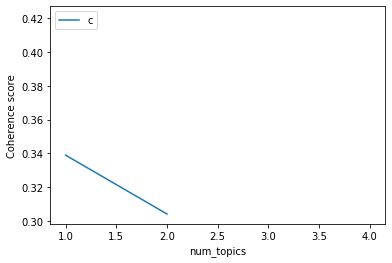

Wall time: 17min 48s


In [423]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=serie_tmp, limit=20)

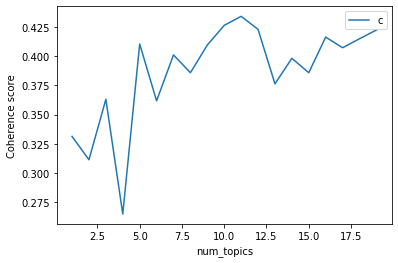

cen	

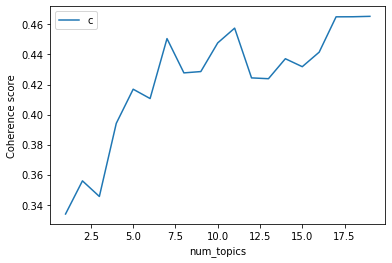

cder	

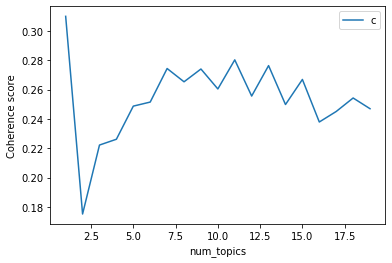

izq	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


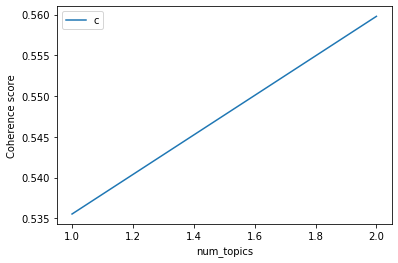

cizq	

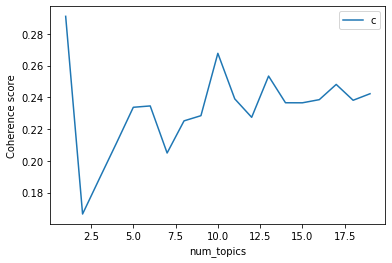

der	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


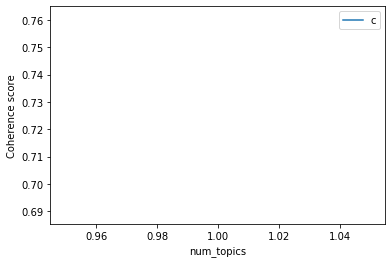

nul	Wall time: 1h 47min 36s


In [424]:
%%time
lista_cv = []
for orientacion in conjunto_orientacion:
    serie_tmp=all_tweets_df.loc[all_tweets_df.Orientacion==orientacion].text_tok
    lmlist2, c_v2 = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=serie_tmp, limit=20)
    lista_cv.append( [orientacion,lmlist2, c_v2 ] )
    print(orientacion, end="\t")

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


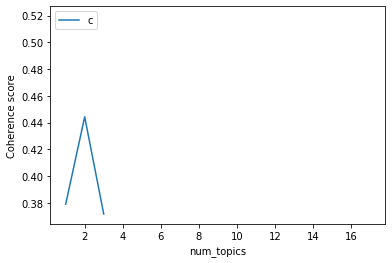

ppc	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


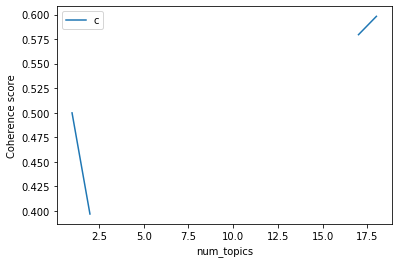

pnp	

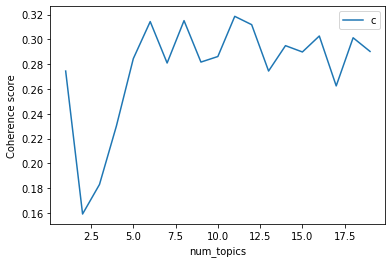

fa	

D:\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
D:\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


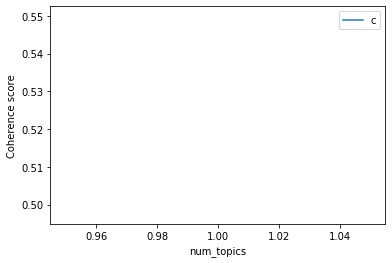

mil	

KeyboardInterrupt: 

In [425]:
%%time
lista_cv2 = []
for partido in conjunto_partidos:
    serie_tmp=all_tweets_df.loc[all_tweets_df.partido==partido].text_tok
    lmlist2, c_v2 = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=serie_tmp, limit=20)
    lista_cv2.append( [orientacion,lmlist2, c_v2 ] )
    print(partido, end="\t")

In [426]:
import pickle

In [85]:

NUM_TOPICS = 10

serie_tmp=all_tweets_db.text_tok

dictionary = corpora.Dictionary(serie_tmp)
corpus = [dictionary.doc2bow(text) for text in  serie_tmp]

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=9)

for topic in topics:
    print(topic)

(0, '0.014*"frente" + 0.013*"peru" + 0.012*"gracias" + 0.012*"amplio"')
(1, '0.011*"fujimori" + 0.008*"agua" + 0.008*"cada" + 0.007*"publica"')
(2, '0.009*"fujimorismo" + 0.007*"solo" + 0.007*"hace" + 0.006*"bien"')
(3, '0.009*"salud" + 0.009*"trabajadores" + 0.008*"pais" + 0.008*"derechos"')
(4, '0.017*"congreso" + 0.016*"comision" + 0.015*"congresista" + 0.009*"debe"')


In [87]:
topics = ldamodel.print_topics(num_words=9)

for topic in topics:
    print(topic)

(0, '0.014*"frente" + 0.013*"peru" + 0.012*"gracias" + 0.012*"amplio" + 0.010*"lima" + 0.007*"vamos" + 0.006*"izquierda" + 0.006*"lucha" + 0.005*"gran"')
(1, '0.011*"fujimori" + 0.008*"agua" + 0.008*"cada" + 0.007*"publica" + 0.007*"keiko" + 0.007*"arana" + 0.007*"posted" + 0.005*"region" + 0.005*"pedro"')
(2, '0.009*"fujimorismo" + 0.007*"solo" + 0.007*"hace" + 0.006*"bien" + 0.005*"puede" + 0.005*"gente" + 0.005*"millones" + 0.005*"ahora" + 0.004*"tambien"')
(3, '0.009*"salud" + 0.009*"trabajadores" + 0.008*"pais" + 0.008*"derechos" + 0.007*"peru" + 0.006*"gobierno" + 0.006*"educacion" + 0.006*"ayacucho" + 0.005*"nacional"')
(4, '0.017*"congreso" + 0.016*"comision" + 0.015*"congresista" + 0.009*"debe" + 0.008*"presidente" + 0.007*"proyecto" + 0.007*"congresistas" + 0.007*"facebook" + 0.006*"corrupcion"')


### **4. Visualización con pyLDAvis**

In [81]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
    

#c_tokens = Counter(politicotweets_all.split()) 
#print(len(c_tokens))
#c_tokens.most_common(15)
politicotweets_all = ' '.join(df_series_text_prep)
    
for idx,scr_name in enumerate(politicosdb_df['screen_name']): 
    df=politicosdf_dict[scr_name[1:]]
    print("Usuario: ",scr_name," / ",politicosdb_df['nombre'].iloc[idx]," / ",politicosdb_df['nombre_partido'].iloc[idx])
    muestra_wordcloud(df.text_prep)